# Sentiment Analysis

In [1]:
# import libraries
import gc
import pandas as pd
from os import chdir
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from gc import collect
import string
from collections import Counter

import sys
sys.path.insert(0, '..')

from src import RAW_TEST_DATA, RAW_TRAIN_DATA, PROCESSED_TRAIN_DATA, PROCESSED_TEST_DATA

In [2]:
# change directory to root
chdir('..')

## Data

In [3]:
# load data
train_data = pd.read_csv(RAW_TRAIN_DATA, names=['label', 'description', 'review'])
test_data = pd.read_csv(RAW_TEST_DATA, names=['label', 'description', 'review'])
print(f'Train data shape: {train_data.shape}')
print(f'Test data shape: {test_data.shape}')

Train data shape: (3000000, 3)
Test data shape: (650000, 3)


In [4]:
# check for missing values in train data
train_data.isnull().sum()

label            0
description    188
review           0
dtype: int64

In [5]:
# check for missing values in test data
test_data.isnull().sum()

label           0
description    26
review          0
dtype: int64

In [6]:
# since we are not using the description column, we can drop it from all the data
train_data = train_data.drop(columns=['description'])
test_data = test_data.drop(columns=['description'])

## Explore the data

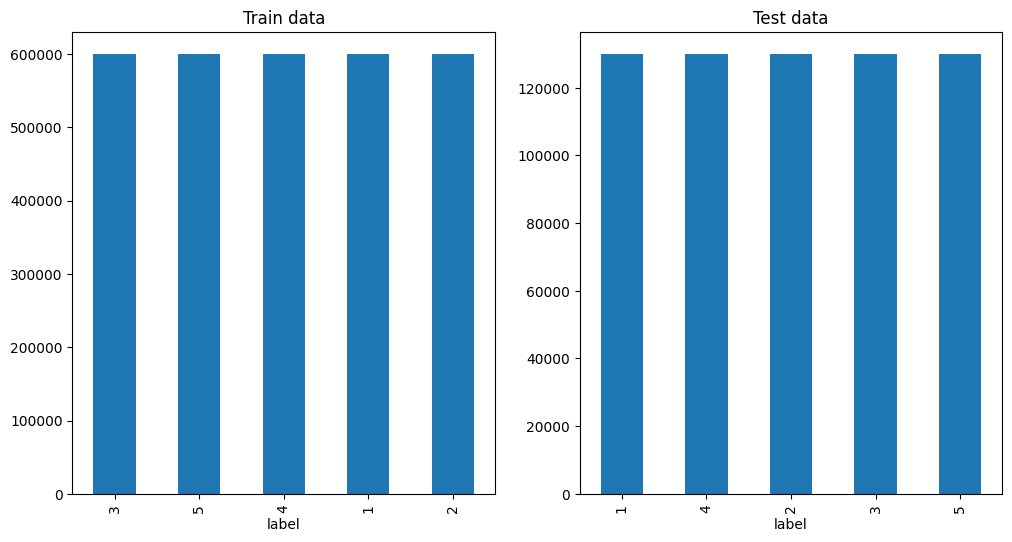

In [7]:
# let's see histogram of the labels in both train and test data
_, ax = plt.subplots(1, 2, figsize=(12, 6))
train_data['label'].value_counts().plot(kind='bar', ax=ax[0], title='Train data')
test_data['label'].value_counts().plot(kind='bar', ax=ax[1], title='Test data')
plt.show()

## Change the labels to positive and negative

According to the data description, 1-2 stars are negative and 4-5 stars are positive, 3 stars are neutral.
Since we are making a binary classification, we can change the labels to negative and positive.
Meaning we can drop the neutral labels.

In [8]:
# drop neutral labels
train_data = train_data[train_data['label'] != 3]
test_data = test_data[test_data['label'] != 3]

# change the labels to 0 for negative and 1 for positive
train_data['label'] = train_data['label'].apply(lambda x: 0 if x < 3 else 1)
test_data['label'] = test_data['label'].apply(lambda x: 0 if x < 3 else 1)

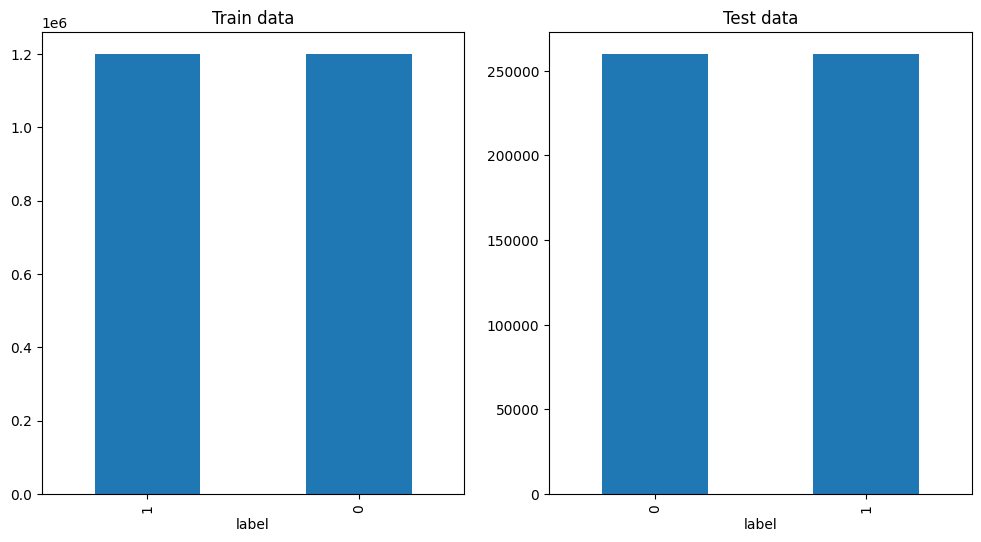

In [9]:
# confirm the changes
_, ax = plt.subplots(1, 2, figsize=(12, 6))
train_data['label'].value_counts().plot(kind='bar', ax=ax[0], title='Train data')
test_data['label'].value_counts().plot(kind='bar', ax=ax[1], title='Test data')
plt.show()

Let's see the first few rows of the data.

In [10]:
train_data.head()

,label,review
1,1,I hope a lot of people hear this cd. We need m...
2,1,I'm reading a lot of reviews saying that this ...
3,1,The music of Yasunori Misuda is without questi...
4,1,Probably the greatest soundtrack in history! U...
5,1,"There's a reason this CD is so expensive, even..."


In [11]:
test_data.head()

,label,review
0,0,"This model may be ok for sedentary types, but ..."
1,1,This is a fast read filled with unexpected hum...
2,0,I bought one of these chargers..the instructio...
3,0,I was excited to find a book ostensibly about ...
4,0,"I am a big JVC fan, but I do not like this mod..."


Now save the data to the processed folder, and use only part of the data for more efficient data analysis and models comparison.

In [12]:
# save the data
train_data.to_csv(PROCESSED_TRAIN_DATA, index=False, header=False)
test_data.to_csv(PROCESSED_TEST_DATA, index=False, header=False)

# Sample the data for further analysis

In [13]:
def sample_data(df, fraction, random_state=42):
    positive = df[df['label'] == 1]
    negative = df[df['label'] == 0]
    
    positive_sample = positive.sample(frac=fraction, random_state=random_state)
    negative_sample = negative.sample(frac=fraction, random_state=random_state)
    
    sampled_data = pd.concat([positive_sample, negative_sample])
    sample_data = sampled_data.sample(frac=1, random_state=random_state)    # shuffle the data
    
    return sample_data

In [14]:
# sample the data to 0.1
train_sampled = sample_data(train_data, 0.1)
test_sampled = sample_data(test_data, 0.1)

In [15]:
# free up memory
del train_data
del test_data
gc.collect()

6006

# Closer look at the sampled data

In [16]:
# Download the necessary nltk data
nltk.download('punkt')
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /home/krystian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/krystian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
# Extract words only from test sample for space efficiency
words = test_sampled['review'].apply(lambda text: word_tokenize(text.lower())).explode()
words_count = words.value_counts().reset_index()
words_count.columns = ['word', 'count']
words_count.head()

,word,count
0,.,208846
1,the,203358
2,",",146605
3,i,114302
4,and,109035


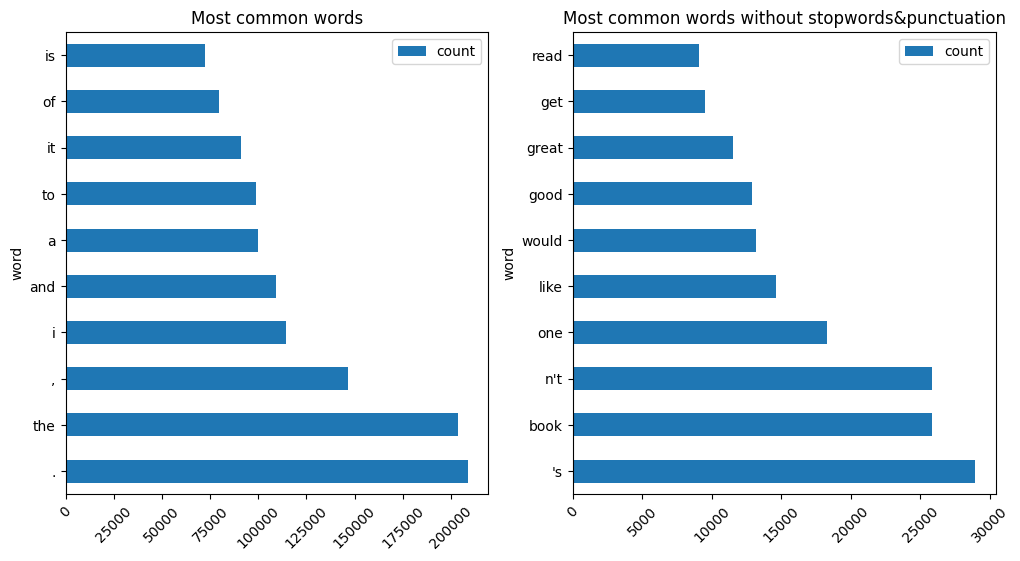

In [61]:
# remove stopwords and punctuation
stopwords_and_punctuation = list(stopwords) + list(string.punctuation) + ['``', "''"]
words_count_processed = words_count[~words_count['word'].isin(stopwords_and_punctuation)]

# plot the most common words for processed data and unprocessed data
_, ax = plt.subplots(1, 2, figsize=(12, 6))
words_count.head(10).plot(kind='barh', x='word', y='count', ax=ax[0], title='Most common words')
words_count_processed.head(10).plot(kind='barh', x='word', y='count', ax=ax[1], title='Most common words without stopwords&punctuation')
ax[0].tick_params(axis="x", rotation=45)
ax[1].tick_params(axis="x", rotation=45)
plt.show()

As we can see, the most common words are stopwords and punctuation. We have to remove them, because they don't provide any useful information for sentiment analysis.